# Turnbull

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import truncnorm

In [32]:
%run ../source/models/iceberg/iceberg.py
%run ../source/models/metocean/metocean.py
%run ../source/models/drift/turnbull.py
%run ../source/plotting/plot.py

# Iceberg

In [3]:
chosen_track_ind = 16
iip_berg_df, iip_df, chosen_inds_arr = get_berg_df(2015, chosen_track_ind)
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,10483,2015,23460,6/25/2015,1111,47.52,-49.42,R/V,LG,GEN,GTJZ,2015-06-25 11:11:00
1,10484,2015,23460,6/25/2015,1859,47.53,-49.49,R/V,LG,GEN,GPGR,2015-06-25 18:59:00
2,10485,2015,23460,6/26/2015,1046,47.46,-49.53,R/V,GEN,GEN,GTJZ,2015-06-26 10:46:00
3,10486,2015,23460,6/27/2015,1036,47.44,-49.51,R/V,LG,GEN,GPGR,2015-06-27 10:36:00
4,10487,2015,23460,6/27/2015,1331,47.42,-49.53,RAD,GEN,GEN,2005,2015-06-27 13:31:00


In [4]:
chosen_inds_arr.sort(key=len, reverse=True)

In [5]:
iip_berg_df = iip_df.loc[chosen_inds_arr[0]].reset_index()
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,10822,2015,23525,6/24/2015,1306,47.71,-49.50,R/V,LG,GEN,GTJZ,2015-06-24 13:06:00
1,10823,2015,23525,6/25/2015,1118,47.55,-49.41,R/V,LG,GEN,GTJZ,2015-06-25 11:18:00
2,10824,2015,23525,6/25/2015,1918,47.49,-49.44,R/V,LG,GEN,GPGR,2015-06-25 19:18:00
3,10825,2015,23525,6/26/2015,1046,47.46,-49.45,R/V,GEN,GEN,GTJZ,2015-06-26 10:46:00
4,10826,2015,23525,6/26/2015,1636,47.43,-49.44,R/V,LG,GEN,GMRS,2015-06-26 16:36:00
5,10827,2015,23525,6/27/2015,1105,47.38,-49.47,R/V,LG,GEN,GPGR,2015-06-27 11:05:00
6,10828,2015,23525,6/27/2015,1331,47.35,-49.49,RAD,GEN,GEN,2005,2015-06-27 13:31:00


In [11]:
iip_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'].loc[0],
                    iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                    [0], [0],
                    iip_berg_df['SIGHTING_LATITUDE'].loc[:].tolist(),
                    iip_berg_df['SIGHTING_LONGITUDE'].loc[:].tolist(),
                    iip_berg_df['SIZE'].loc[0],
                    iip_berg_df['SHAPE'].loc[0])

# Metocean

In [12]:
ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [13]:
ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150624.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150625.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150626.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150627.nc']

In [14]:
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                     min(iip_berg.lats), max(iip_berg.lats),
                     iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [15]:
atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150624.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150625.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150626.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150627.nc']

# Driver

In [16]:
vary_wind = True
vary_current = True

# Run number
run_num = 0
num_runs = 50
mod_berg_list = []
run_param_list = []



# Buffer number for bounding spatial box
buf = 0.5


for run_num in range(num_runs):

    # Create model iceberg
    mod_berg = Iceberg(iip_berg_df['ICEBERG_NUMBER'][0],
                        [iip_berg_df['TIMESTAMP'].dt.to_pydatetime()[0]],
                        [0], [0],
                        [iip_berg_df['SIGHTING_LATITUDE'][0]],
                        [iip_berg_df['SIGHTING_LONGITUDE'][0]],
                        iip_berg_df['SIZE'][0], iip_berg_df['SHAPE'].loc[0])

    mod_berg.length = [mod_berg.length]
    mod_berg.width = [mod_berg.width]
    mod_berg.height = [mod_berg.height]


    # Timesteps
    t0 = iip_berg.datetimes[0]
    tf = iip_berg.datetimes[-1]
    t_delta = tf - t0
    t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
    t_step_hours = 0.1
    t_step = timedelta(hours = t_step_hours)
    dt = t_step_hours*3600  # timestep in seconds
    t_all = []
    for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
        new_date = t0 + timedelta(hours=i)
        t_all.append(new_date)

    # Input field offsets
    # Note: average iceberg speed around NL is 0.2 m/s
    # Note: reasonable mean u,v velocities of current are: 0.11, -0.13 m/s 
    vwu_offset = truncnorm.rvs(-1,1, loc=ocean_data.mean_u, scale=ocean_data.std_u) 
    vwv_offset = truncnorm.rvs(-1,1, loc=ocean_data.mean_v, scale=ocean_data.std_v) 
    vw_offset = np.sqrt(vwu_offset**2 + vwv_offset**2)
    vw_dir_offset = truncnorm.rvs(-np.pi, np.pi, loc=ocean_data.mean_dir, scale=0.5)
    vwu_offset = vw_offset*np.cos(vw_dir_offset)
    vwv_offset = vw_offset*np.sin(vw_dir_offset)
    
    vau_offset = truncnorm.rvs(-20,20, loc=atm_data.mean_u, scale=atm_data.std_u) 
    vav_offset = truncnorm.rvs(-20,20, loc=atm_data.mean_v, scale=atm_data.std_v) 
    va_offset = np.sqrt(vau_offset**2 + vav_offset**2)
    va_dir_offset = truncnorm.rvs(-np.pi, np.pi, loc=atm_data.mean_dir, scale=0.5)
    vau_offset = va_offset*np.cos(va_dir_offset)
    vav_offset = va_offset*np.sin(va_dir_offset)
    
    # Iceberg Initials
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]
    l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
    vx0 = vwu_offset
    vy0 = vwv_offset
    
    l, w, h = l0, w0, h0
    x, y = x0, y0
    vx, vy = vx0, vy0
    
        
    print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))

    for t in t_all:


        t_ocean = nc.date2num(t, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
        t_atm = nc.date2num(t, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
        
        vau = atm_data.iUA([t_atm, y, x])[0]
        vav = atm_data.iVA([t_atm, y, x])[0]
        vwu = ocean_data.iUW([t_ocean, y, x])[0]
        vwv = ocean_data.iVW([t_ocean, y, x])[0]
        #print('vwu, vwv = {}, {}'.format(np.round(vwu,2), np.round(vwv,2)))
        
        if vary_current:
            vwu += vwu_offset
            vwv += vwv_offset
        
        if vary_wind:
            vau += vau_offset
            vav += vav_offset
        
        #print('Timestep: {}'.format(t))

        vx, vy, x, y = turnbull_drift(mod_berg, vau, vav, vwu, vwv, dt) 


        if x > max(iip_berg.lons)+buf or x < min(iip_berg.lons)-buf or y > max(iip_berg.lats)+buf or y <= min(iip_berg.lats)-buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        else:
            mod_berg.xvels.append(vx)
            mod_berg.yvels.append(vy)
            mod_berg.lons.append(x)
            mod_berg.lats.append(y)
            mod_berg.datetimes.append(t)

    #mod_berg.datetimes.pop(0)
    print("Final time: {}".format(t)) 

    mod_berg_list.append(mod_berg)
    run_param_list.append([vau_offset, vav_offset, vwu_offset, vwv_offset])
    

Run number: 0, h = 300.99139312090074, l = 133.83856771207053, w = 128.2571481197299
Final time: 2015-06-27 13:36:00
Run number: 1, h = 275.5762151074756, l = 166.90137373149275, w = 121.94005535482722
Final time: 2015-06-27 13:36:00
Run number: 2, h = 352.9070972311208, l = 164.71002838560565, w = 158.3527652785457
Final time: 2015-06-27 13:36:00
Run number: 3, h = 311.0469135906561, l = 191.17129686636565, w = 137.78144515923964
Final time: 2015-06-27 13:36:00
Run number: 4, h = 382.31631551694636, l = 157.73621154088195, w = 176.1224945579189
Final time: 2015-06-27 13:36:00
Run number: 5, h = 417.81505573353775, l = 123.89979165824164, w = 152.79000880082617
Final time: 2015-06-27 13:36:00
Run number: 6, h = 286.0832565744652, l = 187.99472627316896, w = 169.13186812787518
Final time: 2015-06-27 13:36:00
Run number: 7, h = 433.93093953706034, l = 149.9508355199072, w = 182.348465229976
Final time: 2015-06-27 13:36:00
Run number: 8, h = 408.5164073153918, l = 144.0229290344135, w = 1

# Plotting

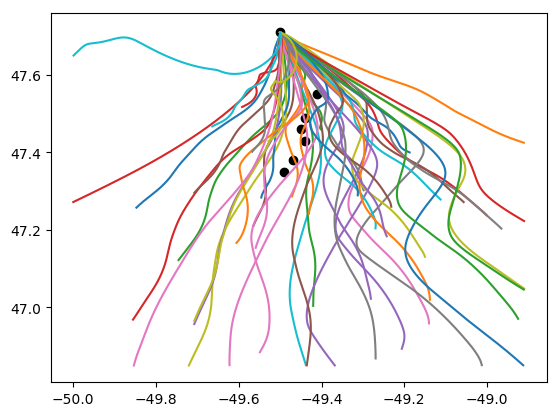

In [17]:
for berg in mod_berg_list:
    plt.plot(berg.lons, berg.lats)
plt.scatter(iip_berg.lons, iip_berg.lats, color='black')
plt.savefig('plots/spaghetti_ind{}.png'.format(chosen_track_ind))

/home/evankielley/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


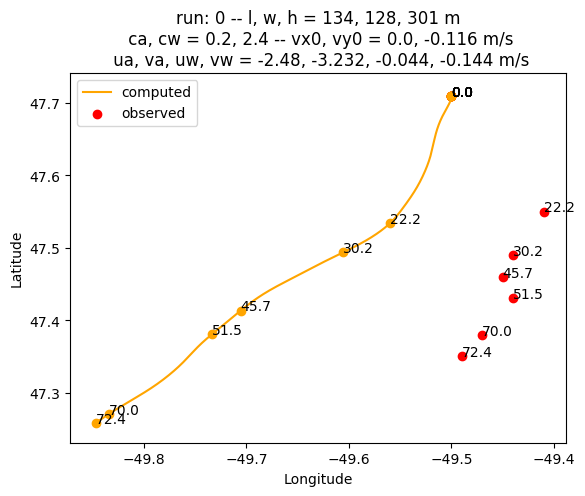

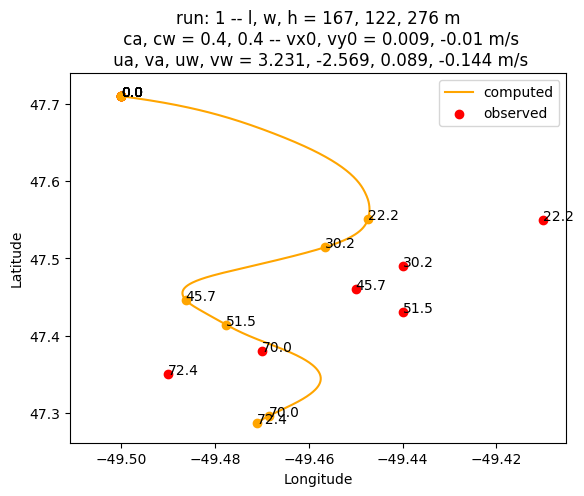

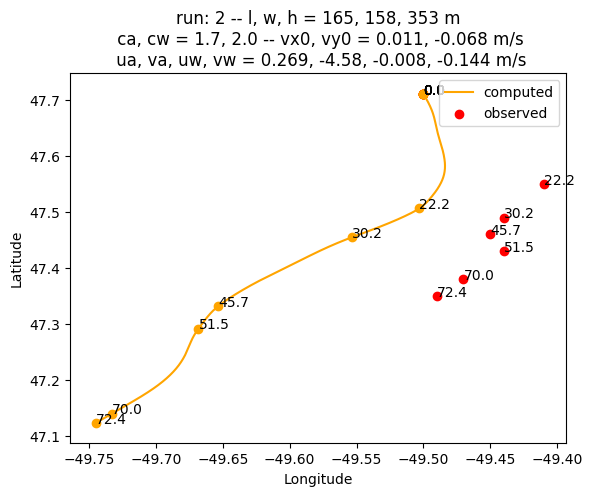

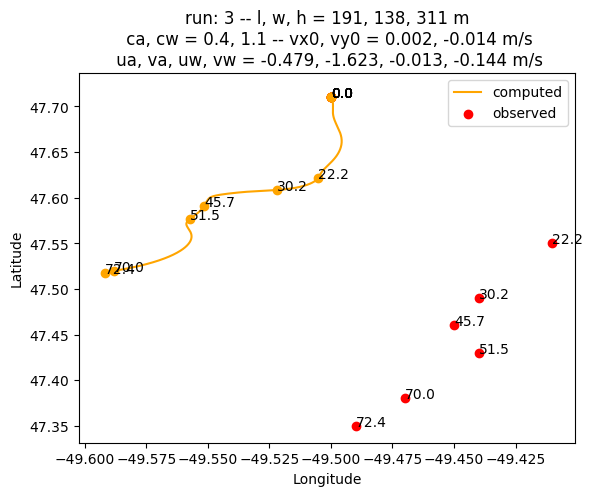

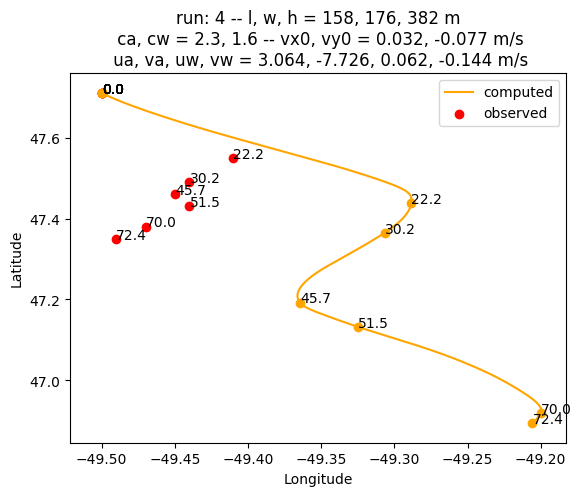

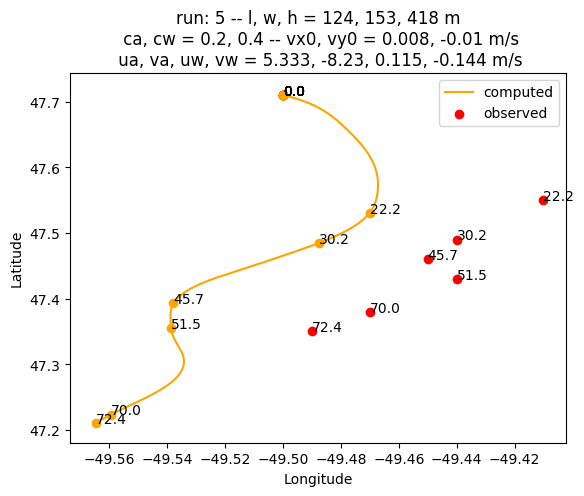

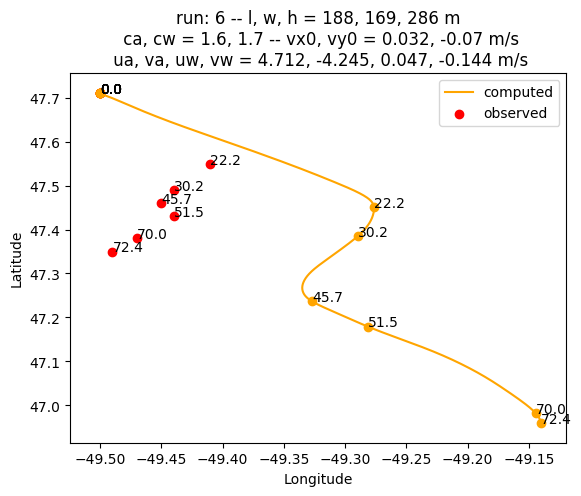

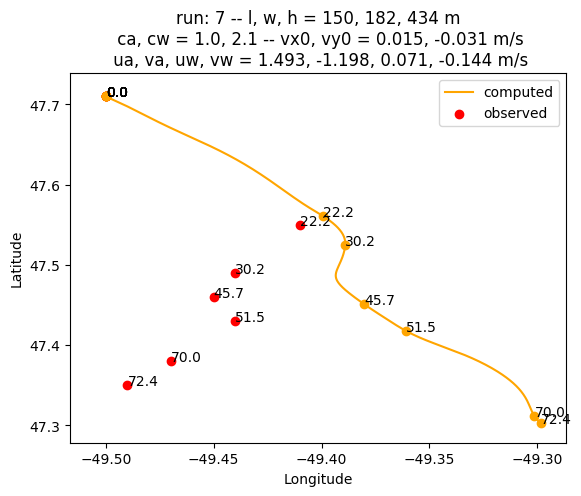

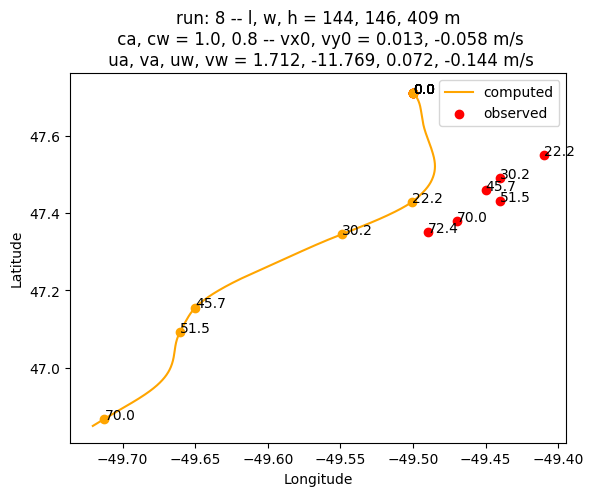

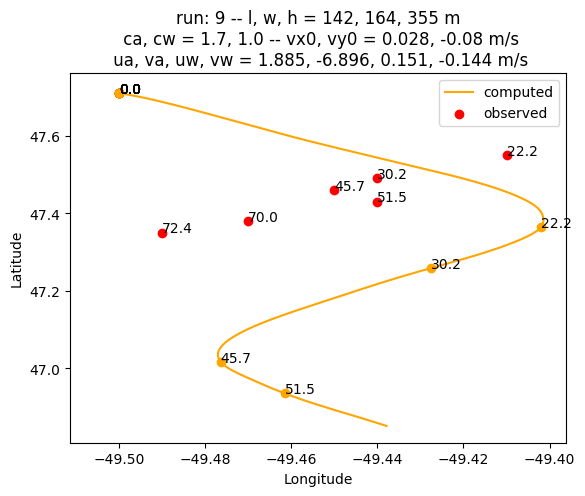

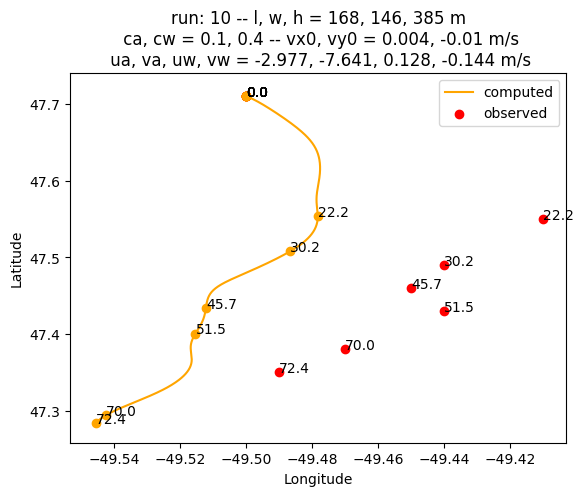

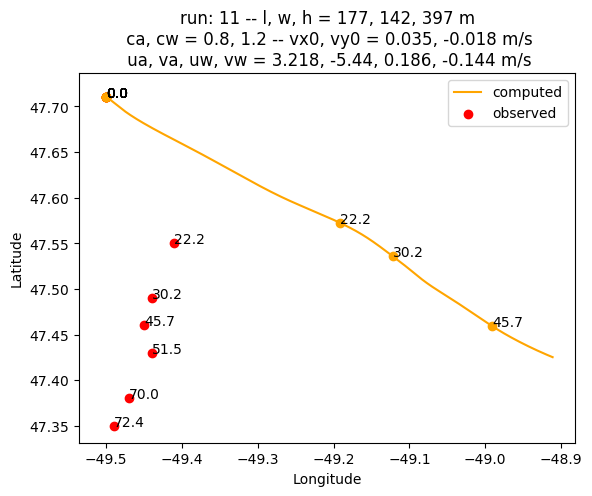

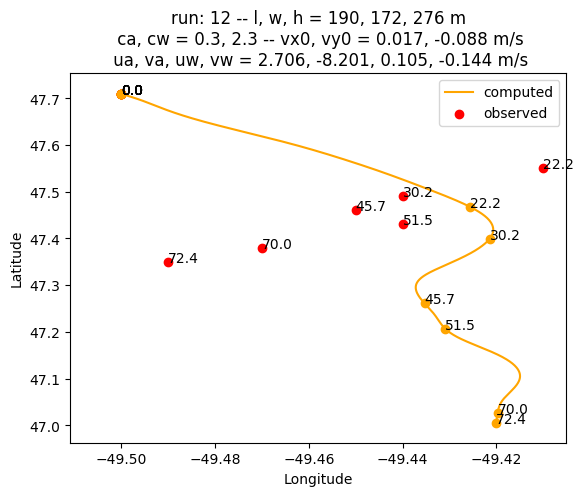

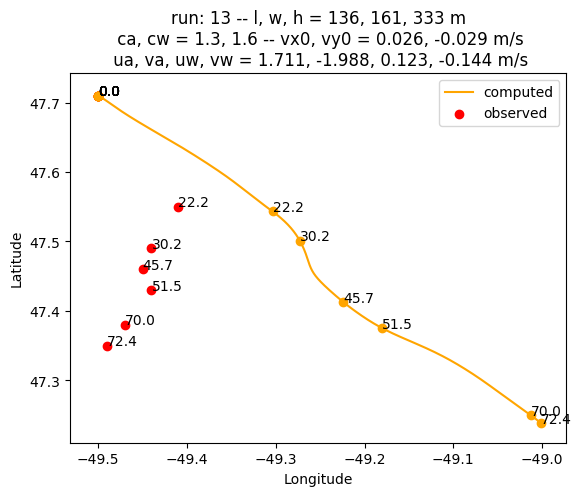

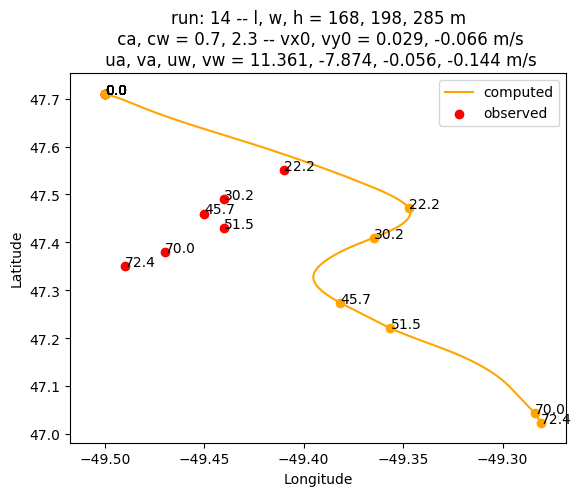

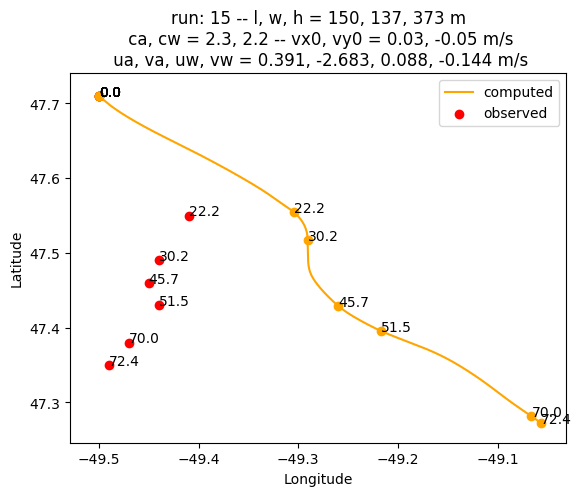

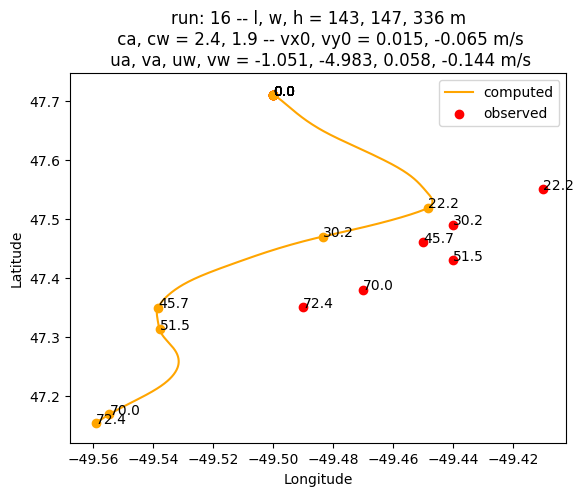

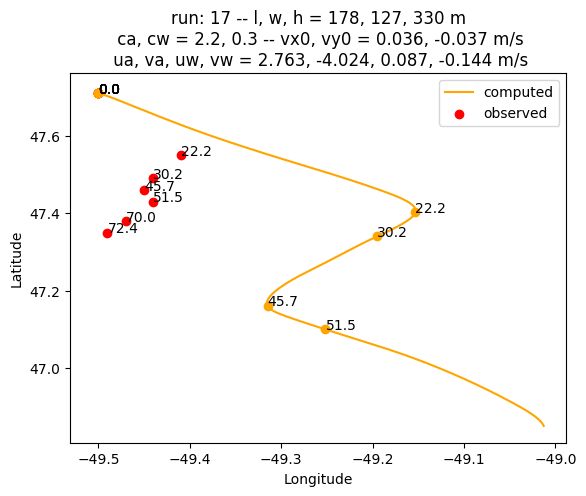

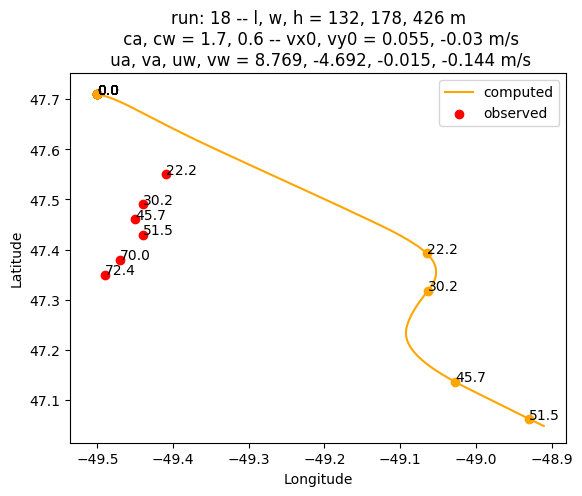

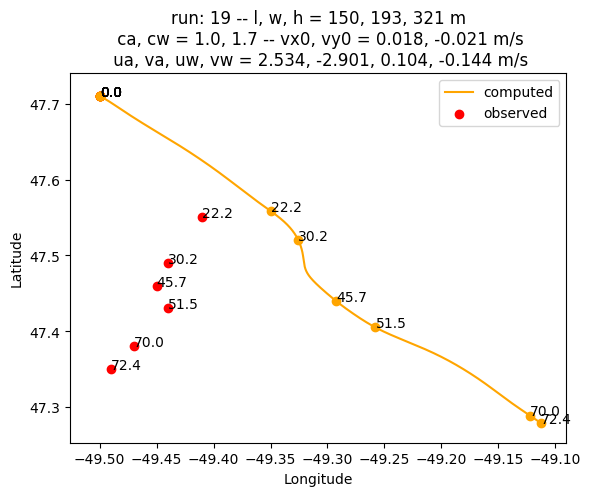

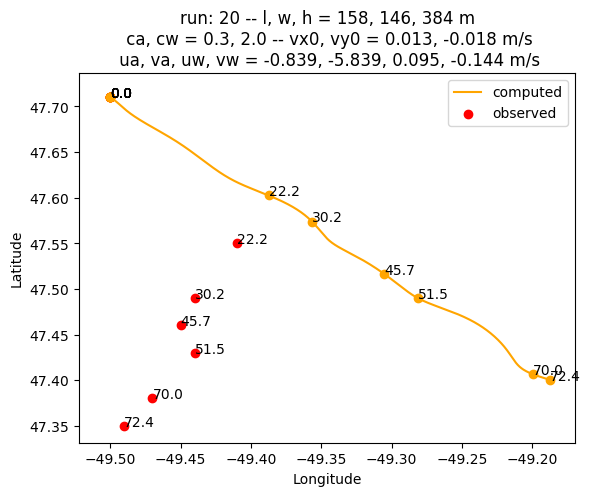

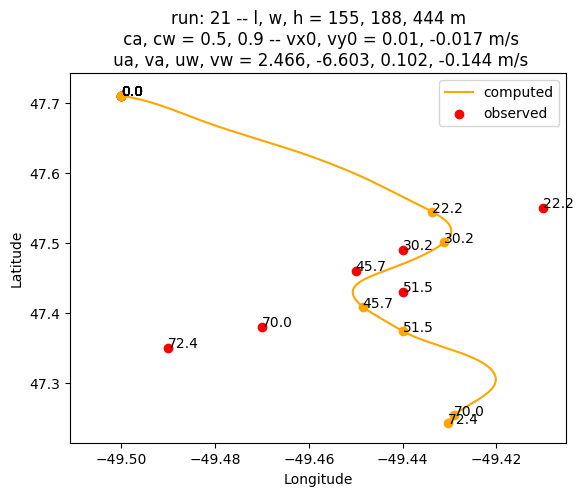

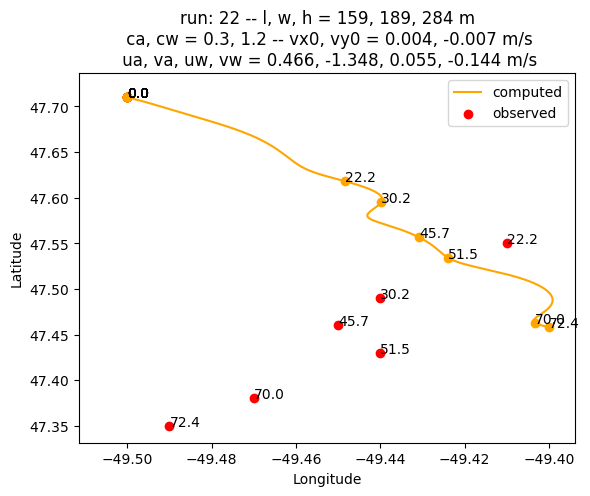

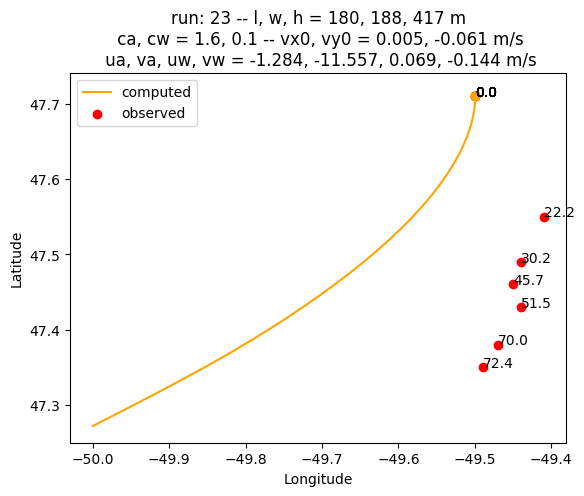

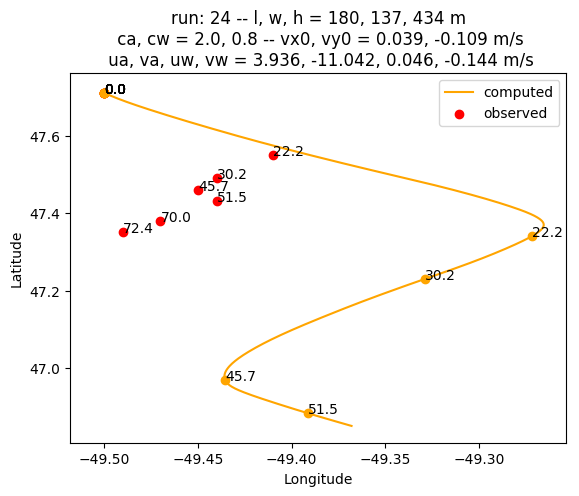

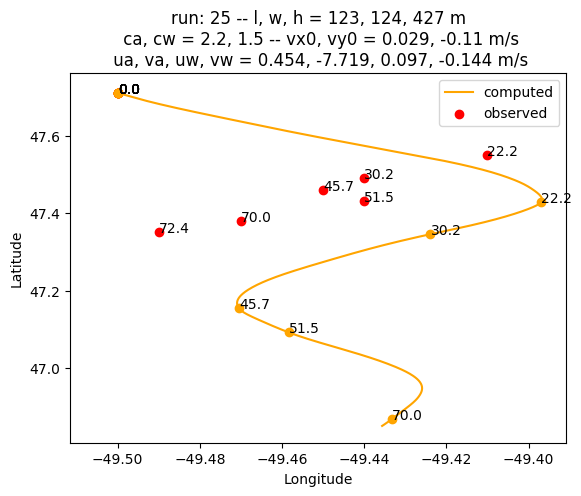

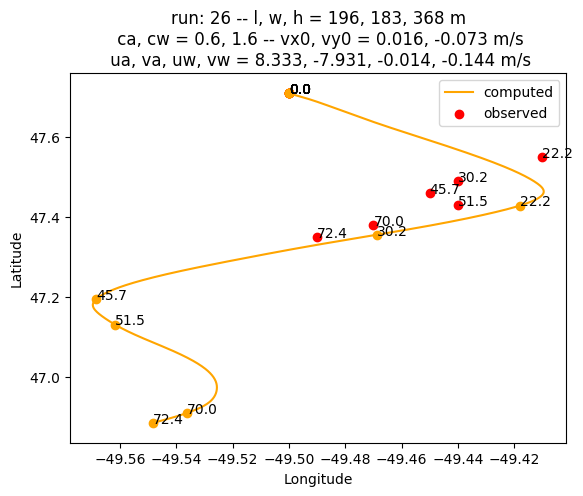

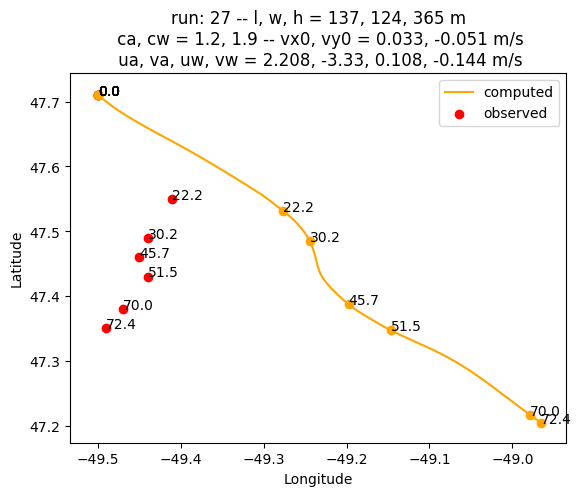

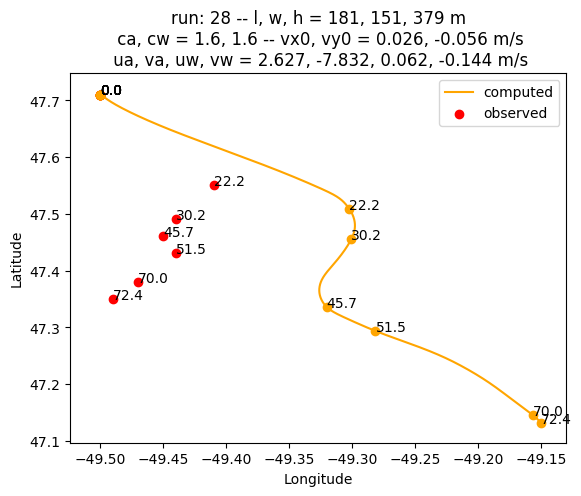

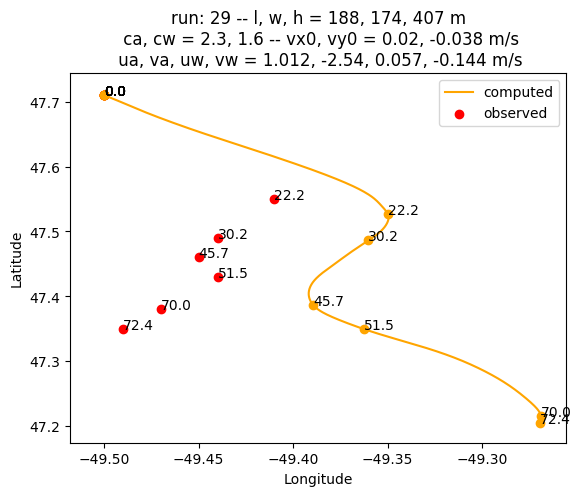

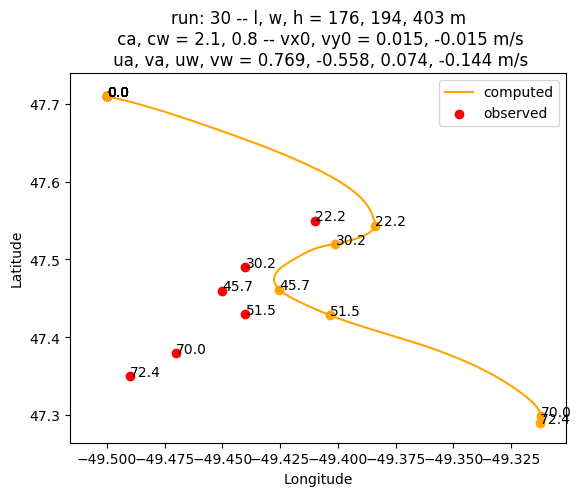

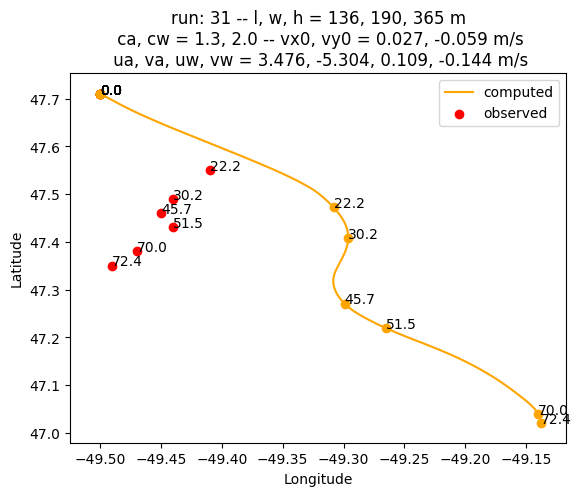

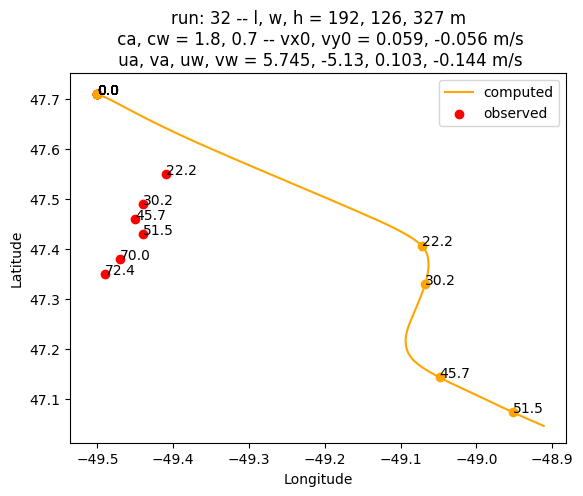

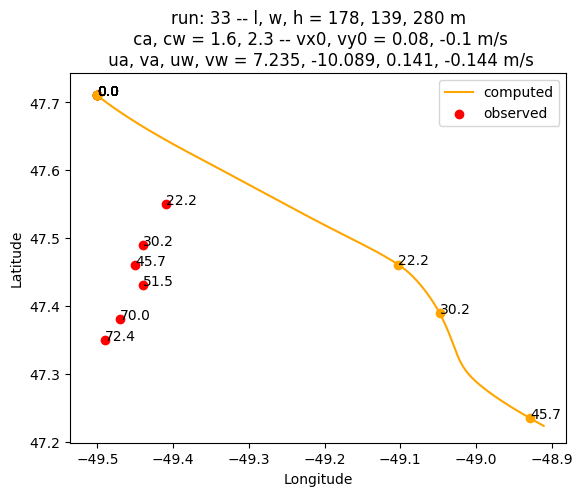

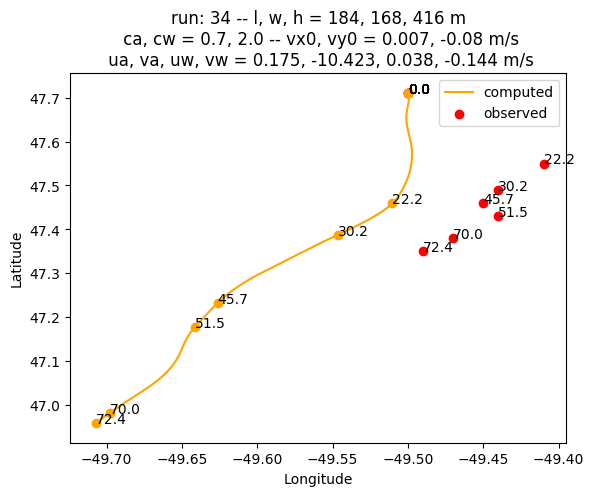

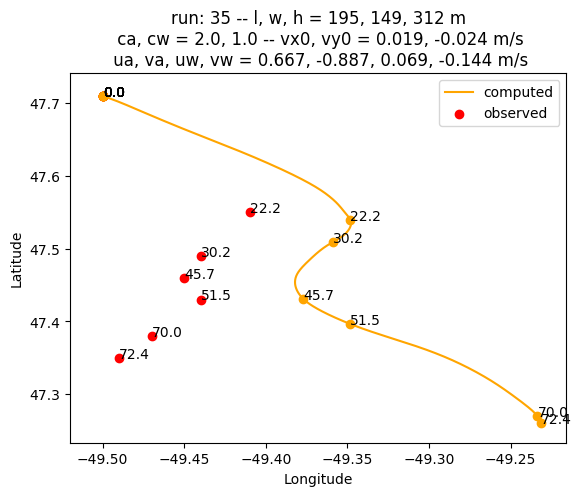

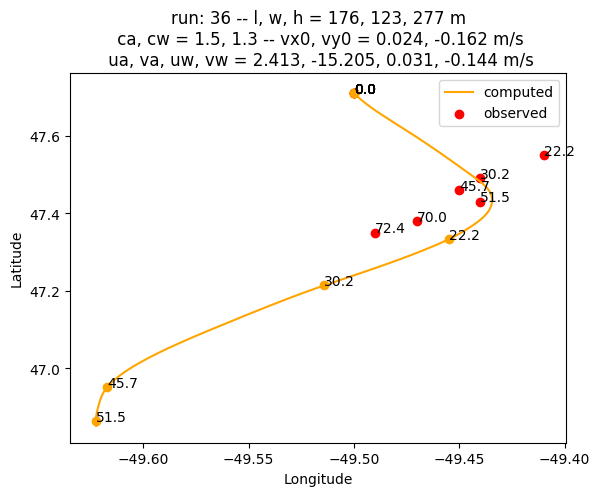

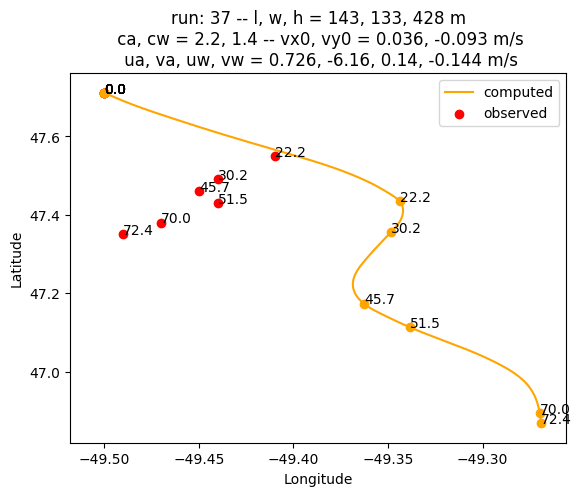

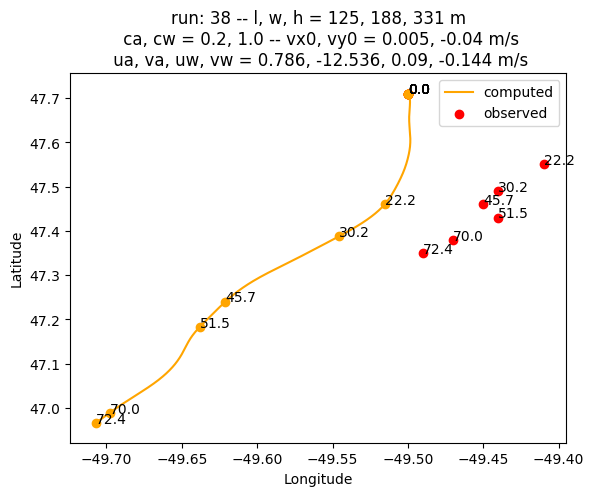

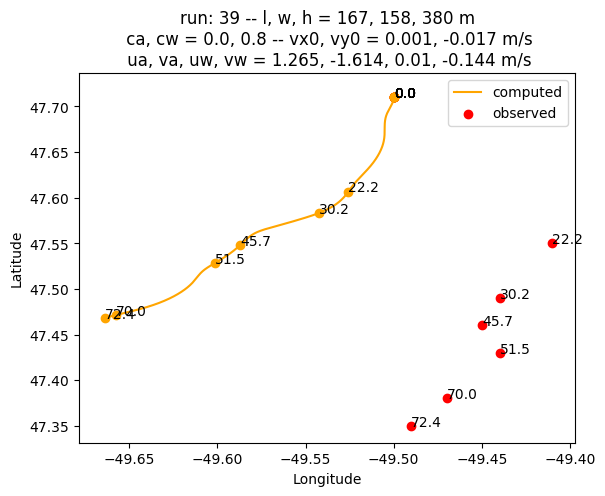

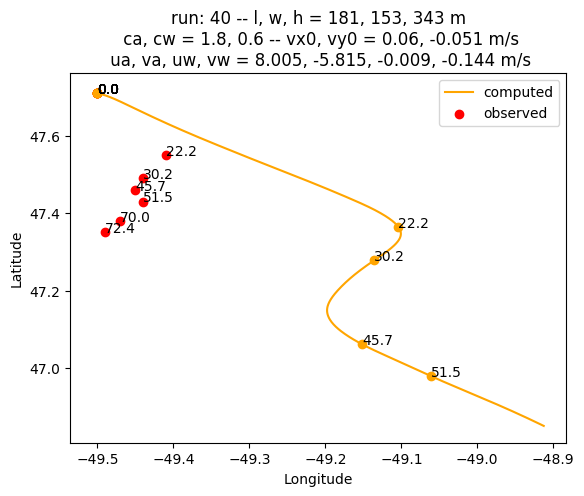

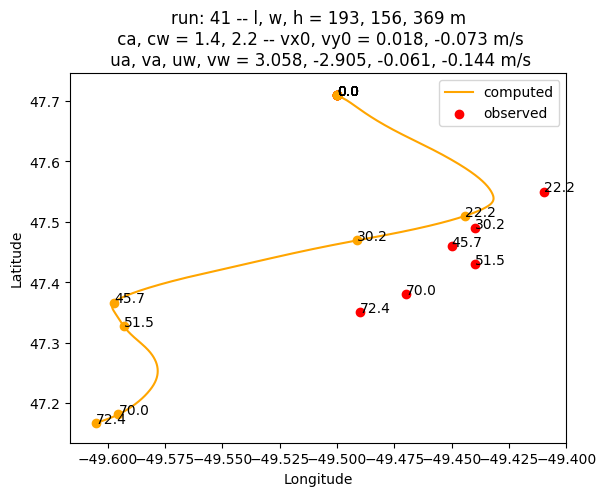

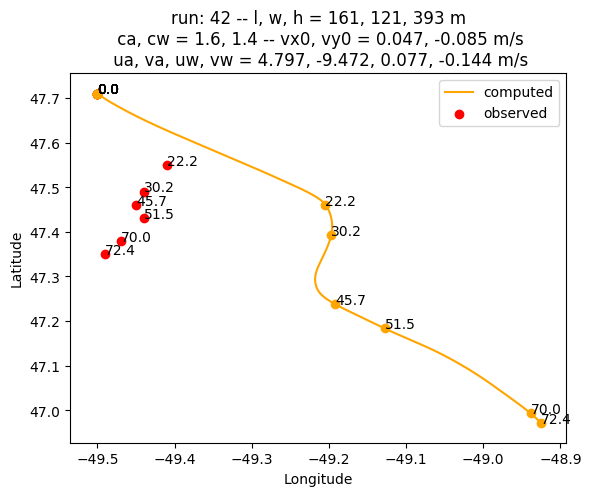

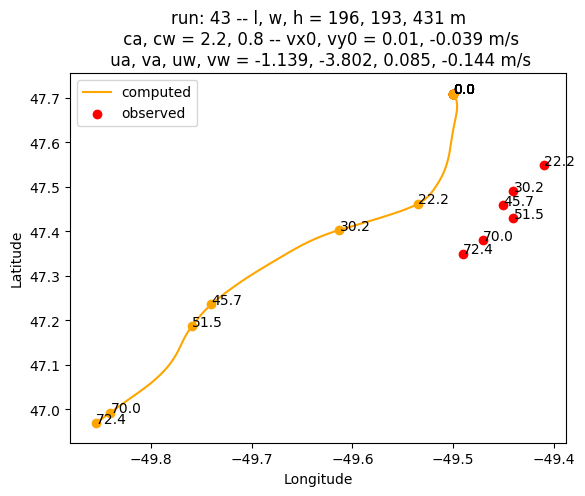

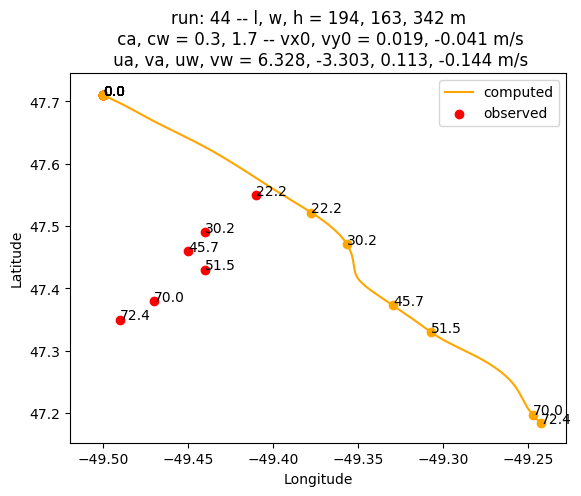

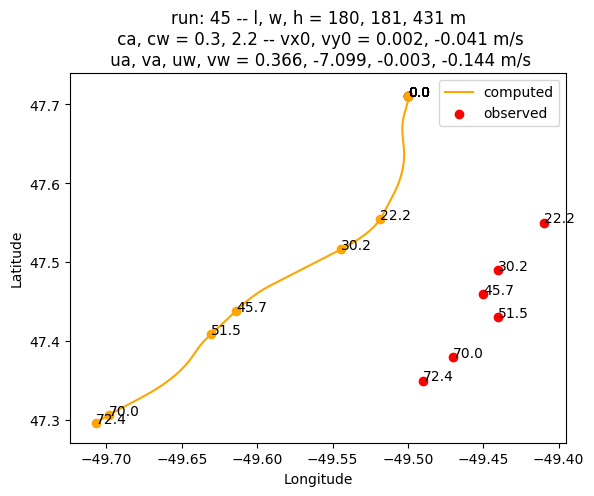

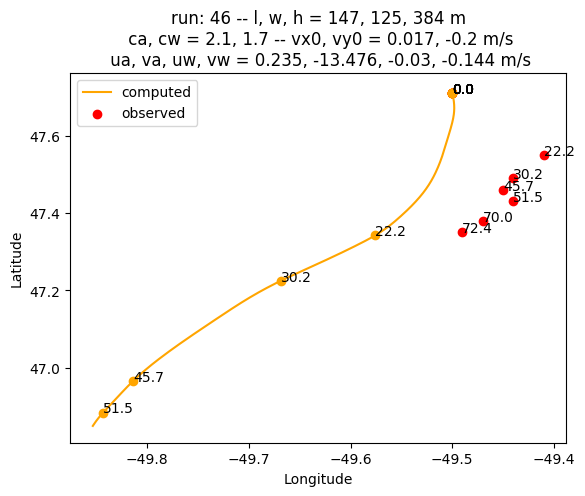

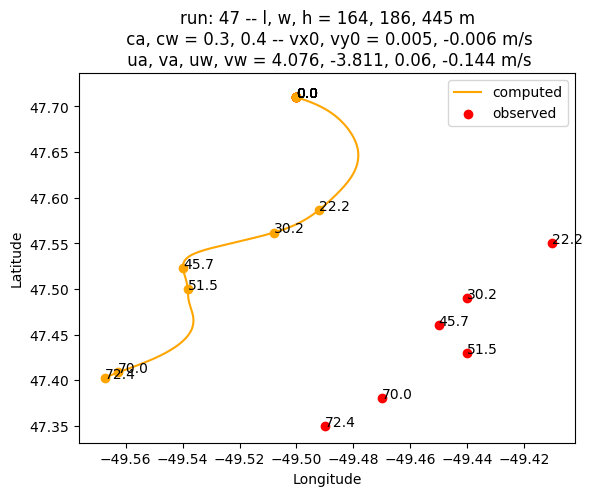

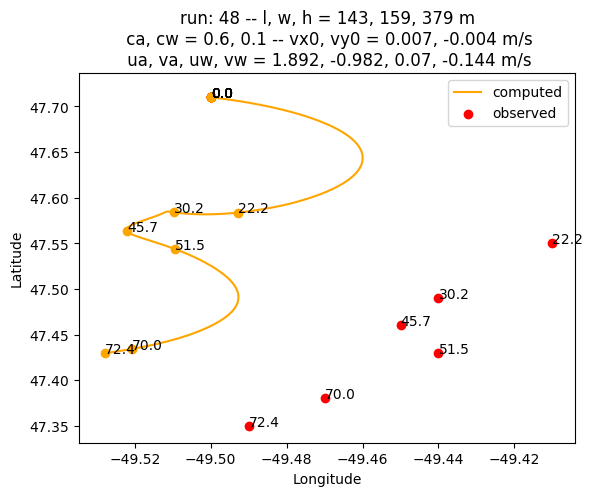

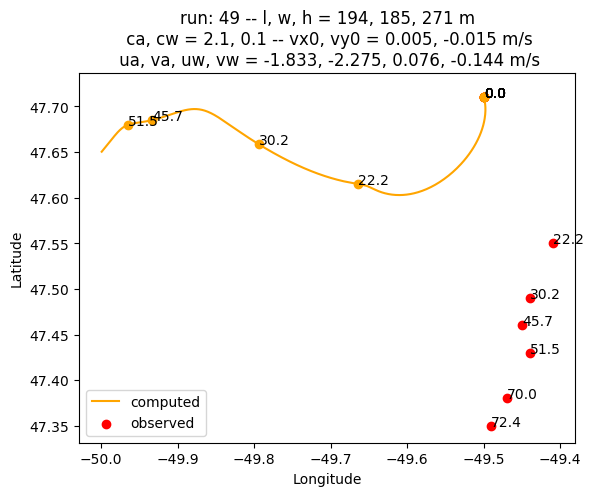

In [35]:
all_iip_times = []
for iip_datetime in iip_berg.datetimes:
    all_iip_times.append(round((iip_datetime - mod_berg.datetimes[0]).total_seconds()/3600,1))
all_iip_times = np.asarray(all_iip_times)

with PdfPages('plots/all_spaghetti.pdf') as pdf:

    for i in range(len(mod_berg_list)):

        all_mod_times = []
        for mod_datetime in mod_berg_list[0].datetimes:
            all_mod_times.append(round((mod_datetime - mod_berg_list[0].datetimes[0]).total_seconds()/3600,1))
        all_mod_times = np.asarray(all_mod_times)

        time_inds = []
        for j in range(all_iip_times.size):
            time_inds.append(np.where(all_mod_times == all_iip_times[j])[0][0])
        
        plot = plot_turnbull(iip_berg, mod_berg_list[i])

        for time_ind in time_inds:

            if time_ind < len(mod_berg_list[i].datetimes):
                plt.scatter(mod_berg_list[i].lons[time_ind], mod_berg_list[i].lats[time_ind], color='orange')
                plt.annotate('{}'.format(all_mod_times[time_ind]), xy=(mod_berg_list[i].lons[time_ind], mod_berg_list[i].lats[time_ind]))

        plt.title('run: {} -- l, w, h = {}, {}, {} m\n ca, cw = {}, {} -- vx0, vy0 = {}, {} m/s\n ua, va, uw, vw = {}, {}, {}, {} m/s'.
              format(i,round(mod_berg_list[i].length[0]), round(mod_berg_list[i].width[0]), round(mod_berg_list[i].height[0]), 
                     round(mod_berg_list[i].air_drag_coeff, 1), round(mod_berg_list[i].water_drag_coeff,1),
                     round(mod_berg_list[i].xvels[1], 3), round(mod_berg_list[i].yvels[1],3),
                     round(run_param_list[i][0], 3), round(run_param_list[i][1], 3), round(run_param_list[i][2], 3), round(run_param_list[40][3], 3)))

        plt.savefig('plots/run{}.png'.format(i))
        pdf.savefig()
        #plt.close()

# Animations

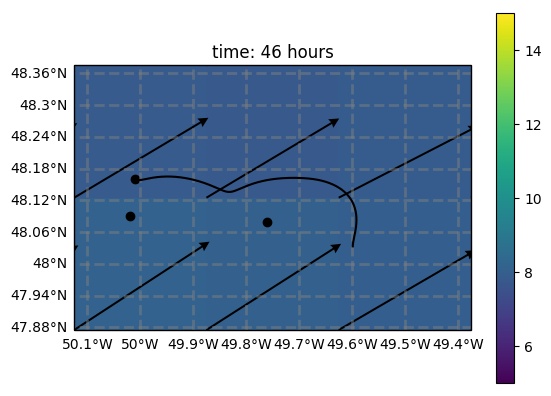

In [27]:
animate_winds(atm_data, iip_berg, mod_berg)

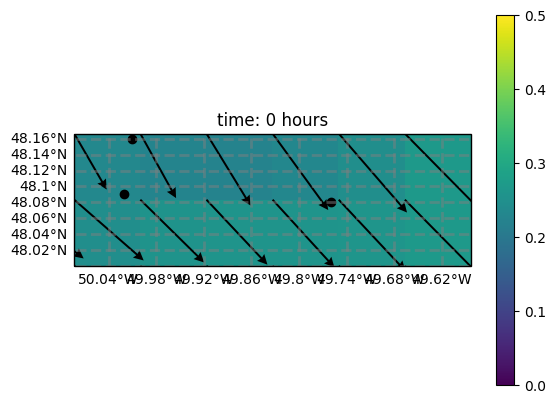

In [28]:
animate_currents(ocean_data, iip_berg, mod_berg)